In [1]:
import urllib.request
import os.path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


#  utilities 

def random_binomial(shape, p=0.0, dtype=None, seed=None):
    """Returns a tensor with random binomial distribution of values.
    # Arguments
        shape: A tuple of integers, the shape of tensor to create.
        p: A float, `0. <= p <= 1`, probability of binomial distribution.
        dtype: String, dtype of returned tensor.
        seed: Integer, random seed.
    # Returns
        A tensor.
    """
    if dtype is None:
        dtype = 'float32'
    if seed is None:
        seed = np.random.randint(10e6)
    return tf.where(tf.random_uniform(shape, dtype=dtype, seed=seed) <= p,
                    tf.ones(shape, dtype=dtype),
                    tf.zeros(shape, dtype=dtype))

#reshape Data
# sample n frame from videos
def my_reshape(data_in ,number_of_frame = 2):
    N, M, H, W = data_in.shape
    n = N-number_of_frame+1
    data_out = np.zeros((n * M, number_of_frame, 64, 64),'uint8')
    for j in range(M):
        for i in range(n):
            data_out[j*n+i] = data_in[i:i+number_of_frame,j]
    
    return data_out

#show filter 
def dispims(M, height, width, border=0, bordercolor=0.0, layout=None, **kwargs):
    from pylab import cm, ceil
    numimages = M.shape[1]
    if layout is None:
        n0 = int(np.ceil(np.sqrt(numimages)))
        n1 = int(np.ceil(np.sqrt(numimages)))
    else:
        n0, n1 = layout
    im = bordercolor * np.ones(((height+border)*n0+border,(width+border)*n1+border),dtype='<f8')
    for i in range(n0):
        for j in range(n1):
            if i*n1+j < M.shape[1]:
                im[i*(height+border)+border:(i+1)*(height+border)+border,
                   j*(width+border)+border :(j+1)*(width+border)+border] = np.vstack((
                            np.hstack((np.reshape(M[:,i*n1+j],(height, width)),
                                   bordercolor*np.ones((height,border),dtype=float))),
                            bordercolor*np.ones((border,width+border),dtype=float)
                            ))
    pylab.imshow(im, cmap=cm.gray, interpolation='nearest', **kwargs)
    pylab.show()
    
# Manage Data
class Dataset:
    def __init__(self,data):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._data = data
        self._num_examples = data.shape[0]
        pass


    @property
    def data(self):
        return self._data

    def next_batch(self,batch_size,shuffle = True):
        start = self._index_in_epoch
        if start == 0 and self._epochs_completed == 0:
            idx = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexe
            self._data = self.data[idx]  # get list of `num` random samples

        # go to the next batch
        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples - start
            data_rest_part = self.data[start:self._num_examples]
            idx0 = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx0)  # shuffle indexes
            self._data = self.data[idx0]  # get list of `num` random samples

            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            data_new_part =  self._data[start:end]  
            return np.concatenate((data_rest_part, data_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._data[start:end]
        
if (not os.path.isfile('log.npy')):
    print ("intialise log")
    log = np.array([])
else :
    print ("load log")
    log =np.load("log.npy")
        
numpy_rng = np.random.RandomState(1)
SMALL = 0.000001
print_every_epoch = 5
batch_size = 64
training_epochs =300

numfac1  = 1024
nummap1  = 512
# numfac1  = 512
# nummap1  = 256
# numfac1  = 256
# nummap1  = 512

numfac2  = 256
nummap2  = 128
# numfac2  = 128
# nummap2  = 64
# numfac2  = 64
# nummap2  = 128

load log


In [2]:
# LOAD DATA
file_name = 'mnist_test_seq.npy'
if not os.path.isfile(file_name):
    print("could not find moving mnist: download it..")
    url = 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'
    urllib.request.urlretrieve(url, file_name)
    print("download complete")
else :
    print ("Data Exist")
    
data = np.load(file_name)
print (data.shape)

num_data = data.shape[1]

idx =  np.arange(0, num_data)
np.random.shuffle(idx)

num_train = int( 0.7 * num_data)
print (num_train)
train_idx = idx[0:num_train]
test_idx = idx [num_train:num_train +1000]

data_train = data[:,train_idx,:,:]
data_test = data[:,test_idx,:,:]


print ("data_train " ,data_train.shape ,"data_test " ,data_test.shape   )

Data Exist
(20, 10000, 64, 64)
7000
data_train  (20, 7000, 64, 64) data_test  (20, 1000, 64, 64)


In [3]:
if not os.path.isfile('mean_all.npy'):
    # Get mean and variance of all frames 
    print ('calculate total mean and var')
    data_1 = (my_reshape(data, 1)).astype('float32')
    print ("data1 shape" , data_1.shape)
    v,n,h,w = data_1.shape
    data_1 = data_1.reshape((v,h * w))
    print ("data1 shape" , data_1.shape)
    mean_all = data_1.mean(0)[None,:]
    data_1 -= mean_all

    var_all = data_1.std(0)[None,:]  + data_1.std() * 0.1

    np.save("mean_all", mean_all)
    np.save("var_all", var_all)
else :
    print ('load mean and var')
    mean_all = np.load('mean_all.npy')
    var_all = np.load('var_all.npy')

print (mean_all.shape)
x_dim = mean_all.shape[1]

load mean and var
(1, 4096)


In [4]:
# Model of  second order relational auto encoder
input_x1 = tf.placeholder(tf.float32, [None, x_dim])
input_x2 = tf.placeholder(tf.float32, [None, x_dim])
input_x3 = tf.placeholder(tf.float32, [None, x_dim])
input_x4 = tf.placeholder(tf.float32, [None, x_dim])

mean = tf.constant(mean_all)
var = tf.constant(var_all)

input_x1_scaled = (input_x1 - mean ) / var
input_x2_scaled = (input_x2 - mean ) / var
input_x3_scaled = (input_x3 - mean ) / var
input_x4_scaled = (input_x4 - mean ) / var


# weights for first layer URR1
if (not os.path.isfile('U1.npy')) and (not os.path.isfile('UR1.npy')) and (not os.path.isfile('URR1.npy')):
    print ("initialize weights randomly")
    U1 = tf.Variable(tf.random_normal(shape=(x_dim, numfac1)) * 0.01)
    V1 = tf.Variable(tf.random_normal(shape=(x_dim, numfac1)) * 0.01)
    W1 = tf.Variable(numpy_rng.uniform(low=-0.01, high=+0.01, size=( numfac1, nummap1)).astype('float32'))

    bias_U1 = tf.Variable(np.zeros(numfac1, dtype='float32'))
    bias_V1 = tf.Variable(np.zeros(numfac1, dtype='float32'))
    bias_W1 = tf.Variable(np.zeros(nummap1, dtype='float32'))
    
    #weights for second layer 
    U2 = tf.Variable(tf.random_normal(shape=(nummap1, numfac2)) * 0.01)
    V2 = tf.Variable(tf.random_normal(shape=(nummap1, numfac2)) * 0.01)
    W2 = tf.Variable(numpy_rng.uniform(low=-0.01, high=+0.01, size=( numfac2, nummap2)).astype('float32'))
    
    bias_U2 = tf.Variable(np.zeros(numfac2, dtype='float32'))
    bias_V2 = tf.Variable(np.zeros(numfac2, dtype='float32'))
    bias_W2 = tf.Variable(np.zeros(nummap2, dtype='float32'))
    
else :
    print ("Load weights")
    U1 = tf.Variable(np.load("URR1.npy"))
    V1 = tf.Variable(np.load("VRR1.npy"))
    W1 = tf.Variable(np.load("WRR1.npy"))
    bias_U1 = tf.Variable(np.load("bias_URR1.npy"))
    bias_V1 = tf.Variable(np.load("bias_VRR1.npy"))
    bias_W1 = tf.Variable(np.load("bias_WRR1.npy"))

    #weights for second layer 
    U2 = tf.Variable(np.load("URR2.npy"))
    V2 = tf.Variable(np.load("VRR2.npy"))
    W2 = tf.Variable(np.load("WRR2.npy"))
    bias_U2 = tf.Variable(np.load("bias_URR2.npy"))
    bias_V2 = tf.Variable(np.load("bias_VRR2.npy"))
    bias_W2 = tf.Variable(np.load("bias_WRR2.npy"))


M1_1 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x1_scaled,U1) +bias_U1 ,tf.matmul(input_x2_scaled,V1)+bias_V1 ), W1)+ bias_W1)
M1_2 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x2_scaled,U1) +bias_U1 ,tf.matmul(input_x3_scaled,V1)+bias_V1 ), W1)+ bias_W1)

M2 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(M1_1,U2)+bias_U2 ,tf.matmul(M1_2,V2) +bias_V2 ), W2)+ bias_W2)

output_M1_3 = tf.matmul(tf.multiply(tf.matmul(M2,tf.transpose(W2)) ,tf.matmul(M1_2,U2) ),tf.transpose(V2))
output_x4 = tf.matmul(tf.multiply(tf.matmul(output_M1_3,tf.transpose(W1)) ,tf.matmul(input_x3_scaled,U1) ),tf.transpose(V1))

cost_RR = tf.nn.l2_loss(output_x4-input_x4_scaled)

optimizer_RR = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_RR)

U1_normalized = tf.nn.l2_normalize(U1, [0,1], epsilon=1e-12, name=None)
V1_normalized = tf.nn.l2_normalize(V1, [0,1], epsilon=1e-12, name=None)
U2_normalized = tf.nn.l2_normalize(U2, [0,1], epsilon=1e-12, name=None)
V2_normalized = tf.nn.l2_normalize(V2, [0,1], epsilon=1e-12, name=None)

normalize_U1 = U1.assign(U1_normalized)
normalize_V1 = V1.assign(V1_normalized)
normalize_U2 = U2.assign(U2_normalized)
normalize_V2 = V2.assign(V2_normalized)


cross_entropy_lost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits = output_x4, labels =input_x4_scaled))

Load weights


In [5]:
#data for second order relational auto encoder
data_2 = my_reshape(data_train, 4) # get 4 frame in each row
 
v,n,h,w = data_2.shape
data_2 = data_2.reshape((v,n,h * w))
print ("data_2 " ,data_2.shape)

ntrain = data_2.shape[0]
dataset2 = Dataset(data_2)
data_2=0

#For Test 
data_test_reshaped = my_reshape(data_test, 4) # get 4 frame in each row
 
v,n,h,w = data_test_reshaped.shape
data_test_reshaped = data_test_reshaped.reshape((v,n,h * w))
print ("data_test_reshaped " ,data_test_reshaped.shape)

ntest = data_test_reshaped.shape[0]

data_2  (119000, 4, 4096)
data_test_reshaped  (17000, 4, 4096)


In [ ]:
#batch_size = 1000
num_batches = int(ntrain/batch_size)
#training_epochs = 300 
best_test_cost = 1000000
with tf.Session() as sess:
    import pylab
    init = tf.global_variables_initializer()
    sess.run(init)
    
    
    for epoch in range(training_epochs):
        total_cost = 0
        for batch_id in range(num_batches):
            batch = (dataset2.next_batch(batch_size)).astype('float32')
            batch_x1s = batch[:,0,:]
            batch_x2s = batch[:,1,:]
            batch_x3s = batch[:,2,:]
            batch_x4s = batch[:,3,:]
     
            sess.run(optimizer_RR, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s, input_x4: batch_x4s})
#             sess.run(normalize_U1)
#             sess.run(normalize_V1)
#             sess.run(normalize_U2)
#             sess.run(normalize_V2)
            cost_ = sess.run(cost_RR, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s, input_x4: batch_x4s}) 
            total_cost += cost_
            #print ("I: %03d/%03d E: %03d i:%03d/%03d cost: %.9f" % (epoch*num_batches+batch_id,training_epochs*num_batches ,epoch,batch_id,num_batches,cost_/batch_size) ) 
        
        
        test_set_cost_= sess.run(cost_RR, feed_dict={input_x1: data_test_reshaped[:,0,:], input_x2: data_test_reshaped[:,1,:], input_x3: data_test_reshaped[:,2,:], input_x4: data_test_reshaped[:,3,:]})
        log = np.append(log,test_set_cost_/ntest )
        
        print ("Epoch: %03d/%03d cost: %.9f  test_cost: %.9f" % (epoch,training_epochs ,total_cost / ntrain ,test_set_cost_/ntest ) )
        if (test_set_cost_< best_test_cost ):
            np.save("URR1", np.array(U1.eval(sess)))
            np.save("VRR1", np.array(V1.eval(sess)))
            np.save("WRR1", np.array(W1.eval(sess)))
            np.save("bias_VRR1", np.array(bias_V1.eval(sess)))
            np.save("bias_URR1", np.array(bias_U1.eval(sess)))
            np.save("bias_WRR1", np.array(bias_W1.eval(sess)))
            np.save("URR2", np.array(U2.eval(sess)))
            np.save("VRR2", np.array(V2.eval(sess)))
            np.save("WRR2", np.array(W2.eval(sess)))
            np.save("bias_URR2", np.array(bias_U2.eval(sess)))
            np.save("bias_VRR2", np.array(bias_V2.eval(sess)))
            np.save("bias_WRR2", np.array(bias_W2.eval(sess)))
            best_test_cost = test_set_cost
        np.save("log", log)



(40, 4096)
test sigmoid cross entropy loss 1415.80152941
test l2 cost 0.114985703412


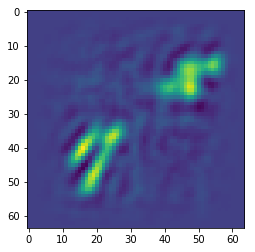

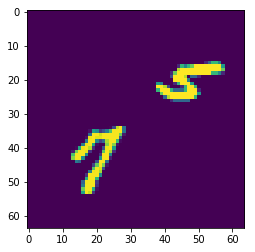

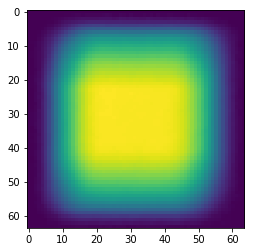

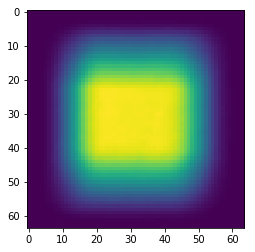

In [15]:
result = 0
test_set_loss=0
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    result = sess.run(output_x4, feed_dict={input_x1: data_test_reshaped[0:40,0,:], input_x2: data_test_reshaped[0:40,1,:], input_x3: data_test_reshaped[0:40,2,:], input_x4: data_test_reshaped[0:40,3,:]})   
    test_set_loss= sess.run(cross_entropy_lost, feed_dict={input_x1: data_test_reshaped[:,0,:], input_x2: data_test_reshaped[:,1,:], input_x3: data_test_reshaped[:,2,:], input_x4: data_test_reshaped[:,3,:]})
    test_set_cost_= sess.run(cost_RR, feed_dict={input_x1: data_test_reshaped[:,0,:], input_x2: data_test_reshaped[:,1,:], input_x3: data_test_reshaped[:,2,:], input_x4: data_test_reshaped[:,3,:]})

    
print (result.shape) 
print("test sigmoid cross entropy loss",test_set_loss/data_test_reshaped.shape[0] )
print("test l2 cost",test_set_cost_/(data_test_reshaped.shape[0]*64*64) )
n=35
result_n =result[n,:] 
result_n =(result_n * var_all.reshape(4096)) +mean_all.reshape(4096)
result_n =result_n.reshape(64,64)

 
plt.imshow(result_n)
plt.show()

plt.imshow(data_test_reshaped[n,3,:].reshape(64,64))
plt.show()  

plt.imshow(var_all.reshape(64,64))
plt.show()

plt.imshow(mean_all.reshape(64,64))
plt.show()
    

In [8]:
log =np.load("log.npy") 
print(log.shape)

(304,)
